# MACHINE LEARNING

Desired output of the turbine: 
- rotor torque
- converter torque
- power output

### Create a set of pipelines & define a parameter grid to optimize kernels

- Linear
- Polynomial
- Kernel Ridge Regression

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autotime

from windml.core.functions import load_one

data_dir = Path.cwd().parent.parent / 'Data Turbines - enriched'
turbine_name = 'R80711'
turbine_csv_file = Path(data_dir, f'{turbine_name}.csv')

df = load_one(turbine_csv_file)
df = df.sample(50000)

Loading time: 1.14 seconds.
Memory usage: 65.67 MB.
261812 Lines found.
time: 4.53 s (started: 2024-04-11 23:51:57 +02:00)


In [2]:
y_variable = 'P_avg'
x_list = [ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg' ]

scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'

time: 673 µs (started: 2024-04-11 23:52:02 +02:00)


In [3]:
from sklearn.model_selection import train_test_split
from windml.visualization.custom_plots import scatter_plot

time: 383 ms (started: 2024-04-11 23:52:02 +02:00)


In [4]:
# Separating the target variable 'y' and features 'X'

X = df[x_list] # take most correlated variables
y = df[y_variable].values.reshape(-1, 1)

# Split the dataset into training and testing sets (20% test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time: 26 ms (started: 2024-04-11 23:52:02 +02:00)


# Linear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'regressor__fit_intercept': True}
Best score (neg_mean_absolute_error): -128.66894870733157


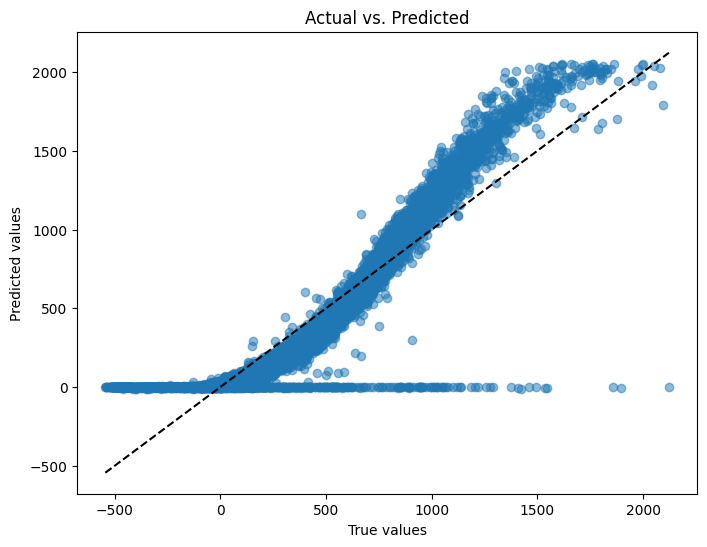

time: 478 ms (started: 2024-04-11 23:52:02 +02:00)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Set up the pipeline with a single step: the linear regression model
lin_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

# Define the parameter grid to search over
lin_param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV with the pipeline and the parameter grid
lin_grid_search = GridSearchCV(lin_pipeline, lin_param_grid, cv=5, scoring=scoring, verbose=1)

# Fit the GridSearchCV to the training data
lin_grid_search.fit(X_train, y_train)

# After fitting, you can check the best parameters and the best score
print("Best parameters:", lin_grid_search.best_params_)
print(f"Best score ({scoring}):", lin_grid_search.best_score_)

# Predictions
y_pred = lin_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

# Polynomial Regression

Best parameters: {'poly_features__degree': 3, 'regressor__fit_intercept': True}
Best score (neg_mean_absolute_error): -26.076034010841283


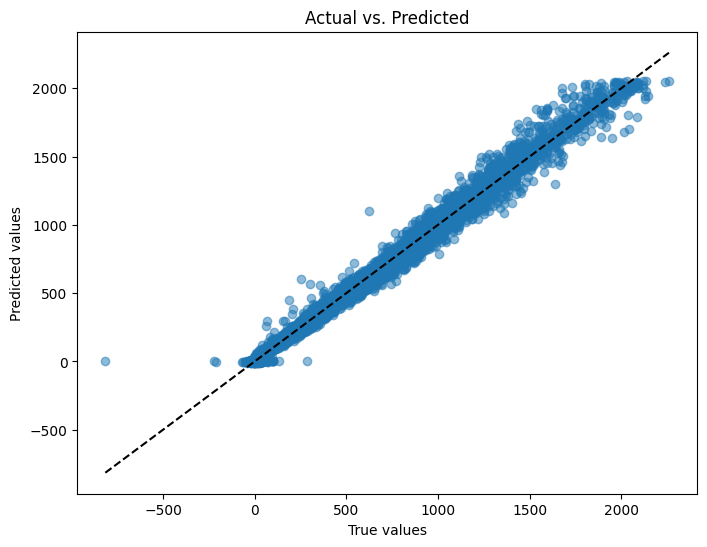

time: 1.29 s (started: 2024-04-11 23:52:03 +02:00)


In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Set up the pipeline
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define the parameter grid
poly_param_grid = {
    'poly_features__degree': [1, 2, 3],  
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV
poly_grid_search = GridSearchCV(poly_pipeline, poly_param_grid, cv=5, scoring=scoring)

# Fit
poly_grid_search.fit(X_train, y_train)

# Print best score
print("Best parameters:", poly_grid_search.best_params_)
print(f"Best score ({scoring}):", poly_grid_search.best_score_)

# Predictions
y_pred = poly_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

# KERNEL RIDGE REGRESSION

### Laplacian (L1) vs Gaussian (L2 or RBF) Kernel
$$ K_{L1}(x, x') = \exp\left(-\gamma \|x - x'\|\right) $$
$$ K_{L2}(x, x') = \exp\left(-\gamma \|x - x'\|^2\right) $$

### Kernel Ridge Regression (KRR)
Kernel Ridge Regression combines Ridge Regression (linear least squares with L2-norm regularization) with the kernel trick. The objective function for KRR is:

$$ \min_{w} \|Xw - y\|^2 + \alpha \|w\|^2 $$

Where:
- $X$ is the matrix of input features.
- $w$ is the vector of coefficients.
- $y$ is the vector of target values.
- $\alpha$ is the regularization parameter.


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

# Set up the pipeline
krr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional but recommended
    ('regressor', KernelRidge())
])

# Define the parameter grid
krr_param_grid = {
    'regressor__kernel': ['rbf'], #, 'manhattan_distances' -> gives awful results
    'regressor__alpha': [1e-4, 1e-2, 1],
    'regressor__gamma': [1e-4, 1e-2, 1],
}

# Initialize GridSearchCV with the pipeline and parameter grid
krr_grid_search = GridSearchCV(krr_pipeline, krr_param_grid, cv=5, scoring=scoring, verbose=1)

# Fit GridSearchCV to the training data
krr_grid_search.fit(X_train, y_train)

# After fitting, you can check the best parameters and the best score
print("Best parameters:", krr_grid_search.best_params_)
print(f"Best score ({scoring}):", krr_grid_search.best_score_)

# Predictions
y_pred = krr_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


# Learning Curve

In [ ]:
from windml.machine_learning.regression_models import learning_curve

# Generate learning curve data without GridSearchCV
lin_LC = learning_curve(df, x_list, y_variable, lin_grid_search )
ploy_LC = learning_curve(df, x_list, y_variable, poly_grid_search )
krr_LC = learning_curve(df, x_list, y_variable, krr_grid_search )

In [ ]:
from windml.visualization.custom_plots import plot_learning_curves

# Plotting the learning curve
fig, ax = plot_learning_curves(
    [(lin_LC, 'Lin'),
    (ploy_LC, 'Poly'),
    (krr_LC, 'KRR')],
)

In [ ]:
fig, ax = plt.subplots()
for (lc_data, lc_name) in [(lin_LC, 'Lin'),
                            (ploy_LC, 'Poly'),
                            (krr_LC, 'KRR')]:
    subset_sizes = list(lc_data.keys())
    errors = [lc_data[size]['mae'] for size in subset_sizes]
    ax.scatter(subset_sizes, errors)
    ax.loglog(subset_sizes, errors, label=lc_name, linestyle='--')
    
plt.xlabel('Subset Size')
plt.ylabel(f'MAE')
plt.title('Learning Curve')
plt.xscale('log')
plt.grid(True)

plt.legend()
plt.savefig('learning_curve.jpeg')

# Polynomial regression with enriched data

In [ ]:
y_variable = 'P_avg'
x_list = [ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg', 'rain_1h', 'snow_1h', 'humidity' ]

enriched_ploy_LC = learning_curve(df, x_list, y_variable, poly_grid_search )

In [ ]:
# Plotting the learning curve
fig, ax = plt.subplots()
for (lc_data, lc_name) in [(enriched_ploy_LC, 'Enriched.Poly'),
                            (ploy_LC, 'Poly'),
                          ]:
    subset_sizes = list(lc_data.keys())
    errors = [lc_data[size]['mae'] for size in subset_sizes]
    ax.scatter(subset_sizes, errors)
    ax.loglog(subset_sizes, errors, label=lc_name, linestyle='--')
    
plt.xlabel('Subset Size')
plt.ylabel(f'MAE')
plt.title('Learning Curve')
plt.xscale('log')
plt.grid(True)

plt.legend()
plt.savefig('learning_curve_enriched.jpeg')